In [ ]:
#aysenur
#experiment 1 de jupyter içerisinde weight update edilmediğini farkettim
#detayını gitmedim ama gpu da accelerator kullanmakla alakalı o yüzden her şeyi .py scripte aldım
#scripte aldıklarım aşağıda sırasıyla verildi, bir kere denemesi yapıldı
#sonrasında belirlenen parametrelerle script çalıştırıldı
#CosineWarmupScheduler eklendi

In [ ]:
#https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

In [1]:
!nvidia-smi

Tue Jul  6 10:59:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pytorch_lightning
!pip install wandb
!pip install ta

     |████████████████████████████████| 819kB 6.6MB/s 
     |████████████████████████████████| 645kB 46.8MB/s 
     |████████████████████████████████| 235kB 52.1MB/s 
     |████████████████████████████████| 122kB 54.3MB/s 
     |████████████████████████████████| 10.6MB 36.7MB/s 
     |████████████████████████████████| 829kB 46.6MB/s 
     |████████████████████████████████| 1.3MB 46.2MB/s 
     |████████████████████████████████| 296kB 43.4MB/s 
     |████████████████████████████████| 143kB 44.7MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=6a0a69acdda092f19375802034846a02196691ee7615af855191c4457c18b94b
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uni

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os 
os.chdir('/content/drive/MyDrive/aysenurk/multi_task_price_change_prediction/notebooks')

Mounted at /content/drive


In [12]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   09_ak_experimenting_lstm-2.ipynb
	modified:   10_ak_experimenting_multi_head_attention.ipynb

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	deleted:    ../pipelines/multi_task_price_change_prediction/DataPreparation.py



In [11]:
!git commi

In [4]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers import TensorBoardLogger
import wandb

from DataPreparation import get_data

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, 
                 currency_list,
                 x: np.ndarray, 
                 y: np.ndarray,
                 data_use_type,
                 train_percentage,
                 val_percentage,
                 test_percentage,
                 seq_len, 
                 ):
        self.currencies = currency_list
        self.n_currencies = len(self.currencies)
        self.x = torch.tensor(x[:self.n_currencies].astype(float))#.float()
        self.y = torch.tensor(y[:self.n_currencies].astype(long))#.long()
        self.seq_len = seq_len
        self.data_use_type = data_use_type
        
        
        #self.train_size = int(len(self.x[0]) * train_percentage)
        self.val_size = int(len(self.x[0]) * val_percentage)
        self.test_size = int(len(self.x[0]) * test_percentage)
        self.train_size = len(self.x[0]) - self.val_size - self.test_size 
        print(self.test_size, self.val_size, self.train_size) 
        
        self.train_mean = [self.x[i][:self.train_size].mean() for i in range(self.n_currencies)]
        self.train_std = [self.x[i][:self.train_size].std() for i in range(self.n_currencies)]
        
#         self.train_min = [self.x[i][:self.train_size].min() for i in range(n_currencies)]
#         self.train_max = [self.x[i][:self.train_size].max() for i in range(n_currencies)]
        
    def __len__(self):
        
        if self.data_use_type == "train":
            return self.train_size - ( self.seq_len)

        elif self.data_use_type == "val":
            return self.val_size
  
        else:
            return self.test_size
        
    
    def __getitem__(self, index):
        
        item = dict()
        
        if self.data_use_type =="val":
            index = self.train_size + index - self.seq_len
            
        elif self.data_use_type =="test":
            index = self.train_size + self.val_size + index - self.seq_len
        
        for i in range(self.n_currencies):
            window = self.x[i][index:index+self.seq_len]
            window = (window -self.train_mean[i]) / self.train_std[i]
            
            item[self.currencies[i] + "_window"] = window
            item[self.currencies[i] + "_label"]  = self.y[i][index+self.seq_len]

        return item

In [6]:
X, y, features, dfs = get_data(CURRENCY_LST,
                            N_CLASSES,
                             FREQUENCY, 
                             WINDOW_SIZE,
                             neutral_quantile = NEUTRAL_QUANTILE,
                             log_price=True,
                             remove_trend=REMOVE_TREND,
                             include_indicators = True,
                             include_imfs = False
                            )

NameError: ignored

In [62]:
train_dataset, val_dataset, test_dataset = [TimeSeriesDataset(CURRENCY_LST, 
                                                          X, 
                                                          y, 
                                                          dtype, 
                                                          TRAIN_PERCENTAGE, 
                                                          VAL_PERCENTAGE, 
                                                          TEST_PERCENTAGE, 
                                                          WINDOW_SIZE) for dtype in ['train', 'val', 'test']]

ValueError: ignored

In [48]:
X[0]

array([[4120.98, 4211.08, 4032.62, ..., -1.2968661684355842,
        -1.3053488973032046, -4.639119923081947],
       [4069.13, 4119.62, 3911.79, ..., -1.7201422317065118,
        -1.7351085545220357, -6.279462693812022],
       [4016.0, 4104.82, 3400.0, ..., 0.5976095617529875,
        0.5958309583631305, -5.719379801543956],
       ...,
       [57797.35, 57911.02, 56035.25, ..., -2.1144501324126486,
        -2.1371248289668188, 1220.353645672893],
       [56578.21, 58981.44, 56435.0, ..., 1.0448898966580966,
        1.039468653491582, 1234.1498875166858],
       [57169.39, 57200.0, 53046.69, ..., -6.943191102791191,
        -7.196003096966841, 1141.5173112287287]], dtype=object)

In [26]:
class CosineWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):
    
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)
        
    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]
    
    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [27]:
class LSTM_based_classification_model(pl.LightningModule):
    def __init__(self,
                 train_dataset,
                 val_dataset,
                 test_dataset,
                 calculate_loss_weights,
                 currencies,
                 num_classes,
                 window_size,
                 input_size,
                 batch_size,
                 lstm_hidden_sizes,
                 bidirectional,
                 learning_rate = 1e-3,
                 scheduler_step = 10,
                 scheduler_gamma = 0.1,
                 ):
        
        super().__init__()
        self.num_classes = num_classes
        self.currencies = currencies
        self.num_tasks = len(currencies)
        self.window_size = window_size
        self.input_size = input_size
        self.batch_size = batch_size
        
        self.lstm_hidden_sizes = lstm_hidden_sizes
        self.bidirectional = bidirectional 
        
        if calculate_loss_weights:
            loss_weights = []
            for i in range(self.num_tasks):
                train_labels = [int(train_dataset[n][self.currencies[i] +"_label"] )for n in range(train_dataset.__len__())]
                samples_size = pd.DataFrame({"label": train_labels}).groupby("label").size().to_numpy()
                loss_weights.append((1 / samples_size) * sum(samples_size)/2)
            self.weights = loss_weights
        else:
            self.weights = None
        
        self.lstm_1 = nn.LSTM(input_size = self.input_size, 
                              num_layers=1, 
                              batch_first=True, 
                              hidden_size = self.lstm_hidden_sizes[0], 
                              bidirectional = bidirectional)
        self.batch_norm1 = nn.BatchNorm2d(num_features=self.lstm_hidden_sizes[0])
        
        if len(self.lstm_hidden_sizes) > 1:
            self.lstm_2 = nn.LSTM(input_size = self.lstm_hidden_sizes[0], 
                                  num_layers=1, 
                                  batch_first=True, 
                                  hidden_size = self.lstm_hidden_sizes[1], 
                                  bidirectional = bidirectional)
            self.batch_norm2 = nn.BatchNorm2d(num_features=self.lstm_hidden_sizes[1])

            self.lstm_3 = nn.LSTM(input_size = self.lstm_hidden_sizes[1], 
                                  num_layers=1, 
                                  batch_first=True, 
                                  hidden_size = self.lstm_hidden_sizes[2], 
                                  bidirectional = bidirectional)
            self.batch_norm3 = nn.BatchNorm2d(num_features=self.lstm_hidden_sizes[2])
        
        self.dropout = nn.Dropout(0.5)
        
        self.linear1 =[nn.Linear(self.lstm_hidden_sizes[-1], int(self.lstm_hidden_sizes[-1]/2))] * self.num_tasks
        self.linear1 = torch.nn.ModuleList(self.linear1)
        self.activation = nn.ReLU()
        
        self.output_layers = [nn.Linear(int(self.lstm_hidden_sizes[-1]/2), self.num_classes)] * self.num_tasks
        self.output_layers = torch.nn.ModuleList(self.output_layers)
        
        if self.weights != None:
            self.cross_entropy_loss = [nn.CrossEntropyLoss(weight= torch.tensor(weights).float()) for weights in self.weights]
        else:
            self.cross_entropy_loss = [nn.CrossEntropyLoss() for _ in range(self.num_tasks)]
        
        self.cross_entropy_loss = torch.nn.ModuleList(self.cross_entropy_loss)
        
        self.f1_score = pl.metrics.F1(num_classes=self.num_classes, average="macro")
        self.accuracy_score = pl.metrics.Accuracy()
        
        self.train_dl = DataLoader(train_dataset, batch_size=self.batch_size, shuffle = True)
        self.val_dl = DataLoader(val_dataset, batch_size=self.batch_size)
        self.test_dl = DataLoader(test_dataset, batch_size=self.batch_size)
        
        self.learning_rate = learning_rate
        self.scheduler_step = scheduler_step
        self.scheduler_gamma = scheduler_gamma
        
    def forward(self, x, i):

        batch_size = x.size()[0]
        
        x = x.view(batch_size, self.window_size, self.input_size) #(batch, window_len, feature_size)
        x, _  = self.lstm_1(x)
        
        x = self.dropout(x)

        x = x.reshape(x.size()[-1], batch_size, self.window_size) #(feature_size, batch, window_len)
        x = self.batch_norm1(x.unsqueeze(0))
        
        if len(self.lstm_hidden_sizes) > 1:
            
            x = x.view(batch_size, self.window_size, x.size()[1])
            x, _  = self.lstm_2(x)

            x = self.dropout(x)

            x = x.reshape(x.size()[-1], batch_size, self.window_size) #(feature_size, batch, window_len)
            x = self.batch_norm2(x.unsqueeze(0))

            x = x.view(batch_size, self.window_size, x.size()[1])
            x, _  = self.lstm_3(x)

            x = self.dropout(x)

            x = x.reshape(x.size()[-1], batch_size, self.window_size) #(feature_size, batch, window_len)
            x = self.batch_norm3(x.unsqueeze(0))
        
        x = x.view(batch_size, self.window_size, x.size()[1])
        x = x[:, -1, :] # equivalent to return sequence = False on keras :)
        
        x = self.dropout(x)
        
        x = self.linear1[i](x)
        x = self.activation(x)
                 
        output = self.output_layers[i](x)
    
        return output
    
    
    def training_step(self, batch, batch_nb):
        
        loss = (torch.tensor(0.0, device="cuda:0", requires_grad=True) + \
                torch.tensor(0.0, device="cuda:0", requires_grad=True)) 
        # araştırılabilir
        for i in range(self.num_tasks):
            x, y = batch[self.currencies[i] + "_window"], batch[self.currencies[i] + "_label"]

            output = self.forward(x, i)
            #loss = F.nll_loss(output, y)
            loss += self.cross_entropy_loss[i](output, y)
            
            acc = self.accuracy_score(torch.max(output, dim=1)[1], y)
            self.log(self.currencies[i] +'_train_acc', acc, on_epoch=True, prog_bar=True)

            f1 = self.f1_score(torch.max(output, dim=1)[1], y)
            self.log(self.currencies[i] +'_train_f1', f1, on_epoch=True, prog_bar=True)
        
        loss = loss / torch.tensor(self.num_tasks)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        
        return loss 
    
    def validation_step(self, batch, batch_nb):
        loss = torch.tensor(0.0, device="cuda:0") + torch.tensor(0.0, device="cuda:0")
        
        for i in range(self.num_tasks):
            x, y = batch[self.currencies[i] + "_window"], batch[self.currencies[i] + "_label"]

            output = self(x, i)
            #loss = F.nll_loss(output, y)
            loss += self.cross_entropy_loss[i](output, y)
 
            acc = self.accuracy_score(torch.max(output, dim=1)[1], y)
            self.log(self.currencies[i] +'_val_acc', acc, on_epoch=True, prog_bar=True, reduce_fx=torch.mean)

            f1 = self.f1_score(torch.max(output, dim=1)[1], y)
            self.log(self.currencies[i] +'_val_f1', f1, on_epoch=True, prog_bar=True, reduce_fx=torch.mean)
        
        loss = loss / torch.tensor(self.num_tasks)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
    
    def test_step(self, batch, batch_nb):
        loss = torch.tensor(0.0, device="cuda:0") + torch.tensor(0.0, device="cuda:0")
        
        for i in range(self.num_tasks):
            x, y = batch[ self.currencies[i] + "_window"], batch[self.currencies[i] + "_label"]

            output = self(x, i)
#             print(y, torch.max(output, dim=1)[1])
#             print(F.softmax(output)) # mantıken fark etmiyor
            loss += self.cross_entropy_loss[i](output, y)
            
            acc = self.accuracy_score(torch.max(output, dim=1)[1], y)
            self.log(self.currencies[i] +'_test_acc', acc, on_epoch=True, reduce_fx=torch.mean)

            f1 = self.f1_score(torch.max(output, dim=1)[1], y)
            self.log(self.currencies[i] +'_test_f1', f1, on_epoch=True, reduce_fx=torch.mean)
        
        loss = loss / torch.tensor(self.num_tasks)
        self.log('test_loss', loss, on_epoch=True, reduce_fx=torch.mean)

        
    def configure_optimizers(self):
        
        optimizer = torch.optim.AdamW(model.parameters(), lr= self.learning_rate)#AdamW does weight decay
#         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
#                                                     step_size=self.scheduler_step, 
#                                                     gamma=self.scheduler_gamma)
        
        self.lr_scheduler = CosineWarmupScheduler(optimizer, 
                                                  warmup=50, 
                                                  max_iters=150* self.train_dl.__len__())
        return [optimizer]#, [{"scheduler": scheduler}]
    
    def optimizer_step(self, *args, **kwargs):
        super().optimizer_step(*args, **kwargs)
        self.lr_scheduler.step() # Step per iteration
    
    def train_dataloader(self):
        return self.train_dl

    def val_dataloader(self):
        return self.val_dl

    def test_dataloader(self):
        return self.test_dl

In [28]:
def name_model(config):
    task = "multi_task_" + "_".join(config["currency_list"]) if len(config["currency_list"]) > 1 else "single_task_" + config["currency_list"][0]
    classification = "multi_classification" if config["n_classes"] > 2 else "binary_classification"
    lstm = "stack_lstm" if len(config["lstm_hidden_sizes"]) > 1 else "single_lstm"
    trend_removed = "trend_removed" if config["remove_trend"] else ""
    loss_weighted = "loss_weighted" if config["loss_weight_calculate"] else ""
    indicators  = "indicators" if config["indicators"] else ""
    imfs = "imfs" if config["imfs"] else ""
    return "_".join([task, lstm, loss_weighted, classification, trend_removed])

In [29]:
#deneme 1

In [31]:
X.shape

(1, 1354, 1)

In [32]:
CONFIG = {#fix for this project
          "window_size": 50, 
          "dataset_percentages": [0.97, 0.007, 0.023],
          "frenquency": "D", 
          "neutral_quantile": 0.33,
          "batch_size": 16,
          "bidirectional": False}

In [33]:
config = CONFIG.copy()
config.update({"n_classes": 2,
          "currency_list": ['BTC'],
          "remove_trend": True,
          "lstm_hidden_sizes": [128, 128, 128],
          "loss_weight_calculate": False, 
          "indicators": True, 
          "imfs": False})

In [34]:
MODEL_NAME = name_model(config)

CURRENCY_LST = config["currency_list"]
N_CLASSES = config["n_classes"]
LSTM_HIDDEN_SIZES = config["lstm_hidden_sizes"]
BIDIRECTIONAL = config["bidirectional"]
REMOVE_TREND =config["remove_trend"]
LOSS_WEIGHT_CALCULATE = config["loss_weight_calculate"]

TRAIN_PERCENTAGE, VAL_PERCENTAGE, TEST_PERCENTAGE = config["dataset_percentages"] 
WINDOW_SIZE = config["window_size"]
FREQUENCY = config["frenquency"]
NEUTRAL_QUANTILE = config["neutral_quantile"] if N_CLASSES > 2 else 0 
BATCH_SIZE= config["batch_size"]
INDICATORS = config["indicators"]
IMFS = config["imfs"]
#####

X, y, features, dfs = get_data(CURRENCY_LST,
                            N_CLASSES,
                             FREQUENCY, 
                             WINDOW_SIZE,
                             neutral_quantile = NEUTRAL_QUANTILE,
                             log_price=True,
                             remove_trend=REMOVE_TREND,
                             include_indicators = INDICATORS,
                             include_imfs = IMFS
                            )
INPUT_FEATURE_SIZE = X.shape[-1]

train_dataset, val_dataset, test_dataset = [TimeSeriesDataset(CURRENCY_LST, 
                                                          X, 
                                                          y, 
                                                          dtype, 
                                                          TRAIN_PERCENTAGE, 
                                                          VAL_PERCENTAGE, 
                                                          TEST_PERCENTAGE, 
                                                          WINDOW_SIZE) for dtype in ['train', 'val', 'test']]

config["dataset_sizes"] = [len(train_dataset), len(val_dataset), len(test_dataset)]
####
wandb.init(project="deneme",
           config=config,
           name = MODEL_NAME)
logger = WandbLogger()
#     #logger = TensorBoardLogger("../output/models/lstm_model_logs", name="lstm_multi_task")

model = LSTM_based_classification_model(
    train_dataset = train_dataset,
     val_dataset = val_dataset,
     test_dataset = test_dataset,
     calculate_loss_weights = LOSS_WEIGHT_CALCULATE,
     currencies = CURRENCY_LST,
     num_classes = N_CLASSES,
     window_size = WINDOW_SIZE,
     input_size = INPUT_FEATURE_SIZE,
     batch_size=BATCH_SIZE,
     lstm_hidden_sizes = LSTM_HIDDEN_SIZES,
     bidirectional = BIDIRECTIONAL)

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.003,
   patience=20,
   verbose=True,
   mode='min'
)

trainer = pl.Trainer(gpus=-1, 
                     max_epochs= 150,
                     logger = logger, 
                     callbacks=[early_stop_callback])
trainer.fit(model)

trainer.test()
wandb.finish()

/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


TypeError: ignored

In [ ]:
#denemeleri tamamlandı experiment_lstm.py dosyasına yazıldı işlemler
def experiment(script):
    !python ../pipelines/multi_task_price_change_prediction/experiment_lstm.py $script

In [ ]:
CONFIG = {#fix for this project
          "window_size": 50, 
          "dataset_percentages": [0.97, 0.007, 0.023],
          "frenquency": "D", 
          "neutral_quantile": 0.33,
          "batch_size": 16,
          "bidirectional": False}

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {"n_classes": [2,3],
          "currency_list": [['BTC'], ['ETH'], ['LTC'], ['BTC', 'ETH'],  ['BTC', 'ETH', 'LTC']],
          "remove_trend": [True, False],
          "lstm_hidden_sizes": [[128], [128, 128, 128]],
          "loss_weight_calculate": [True, False],
          "indicators": [True],
          "imfs": [False]}

In [ ]:
for c in (ParameterGrid(param_grid)):
    config = CONFIG.copy()
    config.update(c)
    script = "--currency-list " + " ".join([i for i in c["currency_list"]])
    script += " --lstm-list " + " ".join([str(i) for i in c["lstm_hidden_sizes"]])
    script += " -trend " + str(1 if c["remove_trend"] else 0)
    script += " -indicators " + str(1 if c["indicators"] else 0)
    script += " -imfs " + str(1 if c["imfs"] else 0)
    script += " -classes " + str(c["n_classes"] )
    script += " -weight " + str(1 if c["loss_weight_calculate"] else 0) 

    experiment(script)

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 00:55:10.435653: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_BTC_single_lstm_loss_weighted_binary_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/1eprgmz4
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_005508-1eprgmz4
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1 

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 00:56:32.154796: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_BTC_single_lstm_loss_weighted_binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/34r9vs22
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_005630-34r9vs22
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | Batc

Epoch 25: 100%|█| 81/81 [00:01<00:00, 76.89it/s, loss=0.692, v_num=vs22, BTC_val
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aysenurk/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Testing: 100%|████████████████████████████████████| 2/2 [00:00<00:00, 98.63it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'BTC_test_acc': 0.5806451439857483,
 'BTC_test_f1': 0.36725807189941406,
 'test_loss': 0.6884135603904724}
--------------------------------------------------------------------------------

wandb: Waiting for W&B process to finish, PID 63051
wandb: Program ended successfully.
wandb:         

Testing: 100%|███████████████████████████████████| 2/2 [00:00<00:00, 118.86it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'BTC_test_acc': 0.4516128897666931,
 'BTC_test_f1': 0.40499287843704224,
 'test_loss': 0.9798224568367004}
--------------------------------------------------------------------------------

wandb: Waiting for W&B process to finish, PID 63252
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_005720-2ae5c60y/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_005720-2ae5c60y/logs/debug-internal.log
wandb: Run summary:
wandb:    BTC_train_acc_step 0.625
wandb:     BTC_train_f1_step 0.613

Epoch 9:  99%|▉| 80/81 [00:00<00:00, 87.09it/s, loss=1.1, v_num=l2tj, BTC_val_ac
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|█| 81/81 [00:00<00:00, 84.18it/s, loss=1.1, v_num=l2tj, BTC_val_ac
Epoch 10:  99%|▉| 80/81 [00:01<00:00, 79.60it/s, loss=1.09, v_num=l2tj, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|█| 81/81 [00:01<00:00, 77.27it/s, loss=1.09, v_num=l2tj, BTC_val_
Epoch 11:  99%|▉| 80/81 [00:00<00:00, 87.03it/s, loss=1.1, v_num=l2tj, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█| 81/81 [00:00<00:00, 84.85it/s, loss=1.1, v_num=l2tj, BTC_val_a
Epoch 12:  99%|▉| 80/81 [00:00<00:00, 92.35it/s, loss=1.1, v_num=l2tj, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█| 81/81 [00:00<00:00, 89.88it/s, loss=1.1, v_num=l2tj, BTC_val_a
                                                                                Metric val_loss improved by 0.018 >= min_delta = 0.003. New best score: 1.119
Epoch 13:  99%|▉| 80/81 [00:00<00:00, 84.05it/s, loss=1.09, v_num=l2tj

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 00:59:11.607819: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_BTC_stack_lstm_loss_weighted_binary_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/28qzo7z2
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_005909-28qzo7z2
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_nor

Epoch 23:  99%|▉| 79/80 [00:02<00:00, 38.15it/s, loss=0.574, v_num=o7z2, BTC_val
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.014 >= min_delta = 0.003. New best score: 0.468
Epoch 23: 100%|█| 80/80 [00:02<00:00, 37.50it/s, loss=0.574, v_num=o7z2, BTC_val
Epoch 24:  99%|▉| 79/80 [00:02<00:00, 30.02it/s, loss=0.591, v_num=o7z2, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|█| 80/80 [00:02<00:00, 29.87it/s, loss=0.591, v_num=o7z2, BTC_val
Epoch 25:  99%|▉| 79/80 [00:02<00:00, 34.04it/s, loss=0.562, v_num=o7z2, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|█| 80/80 [00:02<00:00, 33.89it/s, loss=0.562, v_num=o7z2, BTC_val
Epoch 26:  99%|▉| 79/80 [00:02<00:00, 35.86it/s, loss=0.557, v_num=o7z2, BTC_val
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.015 >= min_delta = 0.003. New best score:

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:01:15.522870: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_BTC_stack_lstm_loss_weighted_binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2ve67el4
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_010114-2ve67el4
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        | B

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'BTC_test_acc': 0.5806451439857483,
 'BTC_test_f1': 0.36725807189941406,
 'test_loss': 0.6858224272727966}
--------------------------------------------------------------------------------

wandb: Waiting for W&B process to finish, PID 63928
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_010114-2ve67el4/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_010114-2ve67el4/logs/debug-internal.log
wandb: Run summary:
wandb:    BTC_train_acc_step 0.5
wandb:     BTC_train_f1_step 0.5
wandb:       train_loss_step 0.68493
wandb:                 epoch 21
wandb:   traine

Epoch 0:  99%|▉| 80/81 [00:01<00:00, 41.94it/s, loss=1.13, v_num=zph0, BTC_val_a
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 1.155
Epoch 0: 100%|█| 81/81 [00:01<00:00, 41.50it/s, loss=1.13, v_num=zph0, BTC_val_a
Epoch 1:  99%|▉| 80/81 [00:01<00:00, 45.16it/s, loss=1.11, v_num=zph0, BTC_val_a
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.034 >= min_delta = 0.003. New best score: 1.121
Epoch 1: 100%|█| 81/81 [00:01<00:00, 44.75it/s, loss=1.11, v_num=zph0, BTC_val_a
Epoch 2:  99%|▉| 80/81 [00:01<00:00, 44.53it/s, loss=1.08, v_num=zph0, BTC_val_a
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.020 >= min_delta = 0.003. New best score: 1.101
Epoch 2: 100%|█| 81/81 [00:01<00:00, 43.97it/s, loss=1.08,

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:04:39.216279: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_BTC_single_lstm__binary_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/3edrij0v
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_010437-3edrij0v
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | Batc

Epoch 27: 100%|█| 80/80 [00:00<00:00, 88.61it/s, loss=0.574, v_num=ij0v, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|█| 80/80 [00:00<00:00, 87.77it/s, loss=0.574, v_num=ij0v, BTC_val
Epoch 28: 100%|█| 80/80 [00:00<00:00, 88.22it/s, loss=0.561, v_num=ij0v, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 28: 100%|█| 80/80 [00:00<00:00, 87.34it/s, loss=0.561, v_num=ij0v, BTC_val
Epoch 29: 100%|█| 80/80 [00:00<00:00, 86.90it/s, loss=0.588, v_num=ij0v, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|█| 80/80 [00:00<00:00, 86.05it/s, loss=0.588, v_num=ij0v, BTC_val
Epoch 30: 100%|█| 80/80 [00:00<00:00, 80.19it/s, loss=0.568, v_num=ij0v, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 30: 100%|█| 80/80 [00:01<00:00, 79.28it/s, loss=0.568, v_num=ij0v, BTC_val
Epoch 31: 100%|█| 80/80 [00:00<00:00, 87.90it/s, loss=0.587, v_num=ij0v, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 31: 100%|█| 80/80 [00:00<00:00, 87.09it/s, loss=0.587, v_num=ij0v, BTC_val
Epoch 32: 100%|█| 80/80 [00:00<00:0

/home/aysenurk/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Epoch 0:  99%|▉| 80/81 [00:00<00:00, 85.95it/s, loss=0.696, v_num=4e86, BTC_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 0.704
Epoch 0: 100%|█| 81/81 [00:00<00:00, 83.41it/s, loss=0.696, v_num=4e86, BTC_val_
Epoch 1:  99%|▉| 80/81 [00:01<00:00, 79.12it/s, loss=0.695, v_num=4e86, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 81/81 [00:01<00:00, 76.31it/s, loss=0.695, v_num=4e86, BTC_val_
Epoch 2:  99%|▉| 80/81 [00:00<00:00, 88.42it/s, loss=0.693, v_num=4e86, BTC_val_
Validatin

Epoch 36:  99%|▉| 80/81 [00:00<00:00, 90.62it/s, loss=0.696, v_num=4e86, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 36: 100%|█| 81/81 [00:00<00:00, 88.01it/s, loss=0.696, v_num=4e86, BTC_val
Epoch 37:  99%|▉| 80/81 [00:00<00:00, 88.52it/s, loss=0.687, v_num=4e86, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 37: 100%|█| 81/81 [00:00<00:00, 86.11it/s, loss=0.687, v_num=4e86, BTC_val
Epoch 38:  99%|▉| 80/81 [00:00<00:00, 91.19it/s, loss=0.694, v_num=4e86, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 38: 100%|█| 81/81 [00:00<00:00, 88.75it/s, loss=0.694, v_num=4e86, BTC_val
Epoch 39:  99%|▉| 80/81 [00:00<00:00, 90.08it/s, loss=0.686, v_num=4e86, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 39: 100%|█| 81/81 [00:00<00:00, 87.51it/s, loss=0.686, v_num=4e86, BTC_val
Epoch 40:  99%|▉| 80/81 [00:00<00:00, 83.32it/s, loss=0.691, v_num=4e86, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 40: 100%|█| 81/81 [00:01<00:00, 80.83it/s, loss=0.691, v_num=4e86, BTC_val
Epoch 41:  99%|▉| 80/81 [00:01<00:0

Epoch 1: 100%|█| 80/80 [00:01<00:00, 79.51it/s, loss=1.01, v_num=caq3, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 80/80 [00:01<00:00, 78.81it/s, loss=1.01, v_num=caq3, BTC_val_a
                                                                                Metric val_loss improved by 0.013 >= min_delta = 0.003. New best score: 0.991
Epoch 2: 100%|█| 80/80 [00:00<00:00, 89.34it/s, loss=1.01, v_num=caq3, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 80/80 [00:00<00:00, 88.45it/s, loss=1.01, v_num=caq3, BTC_val_a
Epoch 3: 100%|█| 80/80 [00:01<00:00, 65.37it/s, loss=1.02, v_num=caq3, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 80/80 [00:01<00:00, 64.85it/s, loss=1.02, v_num=caq3, BTC_val_a
Epoch 4: 100%|█| 80/80 [00:01<00:00, 74.51it/s, loss=0.983, v_num=caq3, BTC_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.033 >= min_delta = 0.003. New best score:

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:07:15.662317: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_BTC_single_lstm__multi_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2md3k6a8
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_010714-2md3k6a8
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | BatchNorm2d | 256 

Epoch 0: 100%|█| 80/80 [00:01<00:00, 43.06it/s, loss=0.701, v_num=5azg, BTC_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 0.657
Epoch 0: 100%|█| 80/80 [00:01<00:00, 42.71it/s, loss=0.701, v_num=5azg, BTC_val_
Epoch 1: 100%|█| 80/80 [00:01<00:00, 45.55it/s, loss=0.657, v_num=5azg, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 80/80 [00:01<00:00, 45.25it/s, loss=0.657, v_num=5azg, BTC_val_
                                                                                Metric val_loss improved by 0.093 >= min_delta = 0.003. New best score: 0.564
Epoch 2: 100%|█| 80/80 [00:01<00:00, 44.26it/s, loss=0.618, v_num=5azg, BTC_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.032 >= min_delta = 0.003. New best score: 0.532
Epoch 2: 100%|█| 80/80 [00:01<00:00, 43.93it/s, loss=0.618

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:09:23.869660: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_BTC_stack_lstm__binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/3cc6sl3t
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_010922-3cc6sl3t
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        | BatchNorm2d | 


wandb: Waiting for W&B process to finish, PID 65576
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_010922-3cc6sl3t/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_010922-3cc6sl3t/logs/debug-internal.log
wandb: Run summary:
wandb:    BTC_train_acc_step 0.5
wandb:     BTC_train_f1_step 0.33333
wandb:       train_loss_step 0.70306
wandb:                 epoch 20
wandb:   trainer/global_step 1680
wandb:              _runtime 51
wandb:            _timestamp 1621462213
wandb:                 _step 75
wandb:   BTC_train_acc_epoch 0.5398
wandb:    BTC_train_f1_epoch 0.3528
wandb:      train_loss_epoch 0.69123
wandb:           BTC_val_acc 0.55556
wandb:            BTC_v

Epoch 12: 100%|█| 80/80 [00:01<00:00, 44.63it/s, loss=1.01, v_num=3uss, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█| 80/80 [00:01<00:00, 44.34it/s, loss=1.01, v_num=3uss, BTC_val_
Epoch 13: 100%|█| 80/80 [00:01<00:00, 44.93it/s, loss=1.03, v_num=3uss, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|█| 80/80 [00:01<00:00, 44.63it/s, loss=1.03, v_num=3uss, BTC_val_
Epoch 14: 100%|█| 80/80 [00:01<00:00, 42.45it/s, loss=0.995, v_num=3uss, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|█| 80/80 [00:01<00:00, 42.18it/s, loss=0.995, v_num=3uss, BTC_val
Epoch 15: 100%|█| 80/80 [00:01<00:00, 43.77it/s, loss=1.03, v_num=3uss, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|█| 80/80 [00:01<00:00, 43.47it/s, loss=1.03, v_num=3uss, BTC_val_
Epoch 16: 100%|█| 80/80 [00:01<00:00, 44.22it/s, loss=1.02, v_num=3uss, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 16: 100%|█| 80/80 [00:01<00:00, 43.90it/s, loss=1.02, v_num=3uss, BTC_val_
Epoch 17: 100%|█| 80/80 [00:02<00:0

Epoch 0:  99%|▉| 80/81 [00:01<00:00, 41.97it/s, loss=1.11, v_num=hfaz, BTC_val_a
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 1.087
Epoch 0: 100%|█| 81/81 [00:01<00:00, 41.02it/s, loss=1.11, v_num=hfaz, BTC_val_a
Epoch 1:  99%|▉| 80/81 [00:01<00:00, 42.73it/s, loss=1.12, v_num=hfaz, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 81/81 [00:01<00:00, 42.31it/s, loss=1.12, v_num=hfaz, BTC_val_a
Epoch 2: 100%|█| 81/81 [00:01<00:00, 45.77it/s, loss=1.08, v_num=hfaz, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 81/81 [00:01<00:00, 45.42it/s, loss=1.08, v_num=hfaz, BTC_val_a
Epoch 3:  99%|▉| 80/81 [00:01<00:00, 47.47it/s, loss=1.09, v_num=hfaz, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 81/81 [00:01<00:00, 47.06it/s, loss=1.09, v_num=hfaz, BTC_val_a
Epoch 4:  99%|▉| 80/81 [00:01<00:00, 40.22it/s, loss=1.11, v_num=hfaz, BTC_val_a
Validating: 0it [00

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:12:38.247830: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_ETH_single_lstm_loss_weighted_binary_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/3si4xqi8
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_011236-3si4xqi8
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1 

Epoch 23: 100%|█| 80/80 [00:00<00:00, 90.38it/s, loss=0.603, v_num=xqi8, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 23: 100%|█| 80/80 [00:00<00:00, 89.49it/s, loss=0.603, v_num=xqi8, ETH_val
Epoch 24: 100%|█| 80/80 [00:00<00:00, 81.54it/s, loss=0.606, v_num=xqi8, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|█| 80/80 [00:00<00:00, 80.86it/s, loss=0.606, v_num=xqi8, ETH_val
Epoch 25: 100%|█| 80/80 [00:01<00:00, 70.23it/s, loss=0.555, v_num=xqi8, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|█| 80/80 [00:01<00:00, 69.69it/s, loss=0.555, v_num=xqi8, ETH_val
Epoch 26: 100%|█| 80/80 [00:01<00:00, 79.14it/s, loss=0.566, v_num=xqi8, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|█| 80/80 [00:01<00:00, 78.07it/s, loss=0.566, v_num=xqi8, ETH_val
Epoch 27: 100%|█| 80/80 [00:01<00:00, 76.24it/s, loss=0.565, v_num=xqi8, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|█| 80/80 [00:01<00:00, 75.61it/s, loss=0.565, v_num=xqi8, ETH_val
Epoch 28: 100%|█| 80/80 [00:00<00:0

/home/aysenurk/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Epoch 0:  99%|▉| 80/81 [00:00<00:00, 90.62it/s, loss=0.703, v_num=gw3b, ETH_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 0.603
Epoch 0: 100%|█| 81/81 [00:00<00:00, 87.76it/s, loss=0.703, v_num=gw3b, ETH_val_
Epoch 1:  99%|▉| 80/81 [00:01<00:00, 79.59it/s, loss=0.709, v_num=gw3b, ETH_val_
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 81/81 [00:01<00:00, 77.45it/s, loss=0.709, v_num=gw3b, ETH_val_
Epoch 2:  99%|▉| 80/81 [00:00<00:00, 88.78it/s, loss=0.696, v_num=gw3b, ETH_val_
Validatin

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:14:10.809025: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_ETH_single_lstm_loss_weighted_multi_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2bbz7omm
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_011409-2bbz7omm
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1  

Epoch 0:  99%|▉| 80/81 [00:00<00:00, 91.85it/s, loss=1.12, v_num=naj0, ETH_val_a
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 1.077
Epoch 0: 100%|█| 81/81 [00:00<00:00, 88.96it/s, loss=1.12, v_num=naj0, ETH_val_a
Epoch 1:  99%|▉| 80/81 [00:01<00:00, 76.68it/s, loss=1.11, v_num=naj0, ETH_val_a
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 81/81 [00:01<00:00, 74.77it/s, loss=1.11, v_num=naj0, ETH_val_a
Epoch 2:  99%|▉| 80/81 [00:00<00:00, 83.68it/s, loss=1.11, v_num=naj0, ETH_val_a
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 81/81 [00:00<00:00, 81.80it/s, loss=1.11, v_num=naj0, ETH_val_a
Epoch 3:  99%|▉| 80/81 [00:00<00:00, 90.50it/s, loss=1.09, v_num=naj0, ETH_val_a
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 81/81 [00:00<00:00, 88.08it/s, loss=1.09, v_num=naj0, ETH_val_a
Epoch 4:  99%|▉| 80/81 [00:00<00:00, 90.75it/s, loss=1.1, v_num=naj0, ETH_val_ac
Validating: 0it [00

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:15:40.917349: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_ETH_stack_lstm_loss_weighted_binary_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/27tapgej
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_011539-27tapgej
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_nor

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:18:04.102915: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_ETH_stack_lstm_loss_weighted_binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2j95iuew
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_011802-2j95iuew
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        | B

Epoch 0: 100%|█| 80/80 [00:02<00:00, 39.57it/s, loss=1.11, v_num=yiu0, ETH_val_a
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 1.092
Epoch 0: 100%|█| 80/80 [00:02<00:00, 39.33it/s, loss=1.11, v_num=yiu0, ETH_val_a
Epoch 1: 100%|█| 80/80 [00:02<00:00, 39.80it/s, loss=1.11, v_num=yiu0, ETH_val_a
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.024 >= min_delta = 0.003. New best score: 1.068
Epoch 1: 100%|█| 80/80 [00:02<00:00, 39.54it/s, loss=1.11, v_num=yiu0, ETH_val_a
Epoch 2: 100%|█| 80/80 [00:02<00:00, 32.97it/s, loss=1.1, v_num=yiu0, ETH_val_ac
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 80/80 [00:02<00:00, 32.78it/s, loss=1.1, v_num=yiu0, ETH_val_ac
Epoch 3: 100%|█| 80/80 [00:02<00:00, 38.22it/s, loss=1.11, v_num=yiu0, ETH_val_a
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 80/80 

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:20:53.070186: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_ETH_stack_lstm_loss_weighted_multi_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/1n4w9wbk
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_012051-1n4w9wbk
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        | Ba

Epoch 1: 100%|█| 80/80 [00:01<00:00, 72.50it/s, loss=0.534, v_num=zi1q, ETH_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.048 >= min_delta = 0.003. New best score: 0.487
Epoch 1: 100%|█| 80/80 [00:01<00:00, 71.90it/s, loss=0.534, v_num=zi1q, ETH_val_
Epoch 2: 100%|█| 80/80 [00:01<00:00, 71.47it/s, loss=0.562, v_num=zi1q, ETH_val_
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 80/80 [00:01<00:00, 70.77it/s, loss=0.562, v_num=zi1q, ETH_val_
Epoch 3: 100%|█| 80/80 [00:01<00:00, 64.50it/s, loss=0.604, v_num=zi1q, ETH_val_
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 80/80 [00:01<00:00, 63.90it/s, loss=0.604, v_num=zi1q, ETH_val_
Epoch 4: 100%|█| 80/80 [00:01<00:00, 66.98it/s, loss=0.616, v_num=zi1q, ETH_val_
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█| 80/80 [00:01<00:00, 66.51it/s, loss=0.616, v_num=zi1q, ETH_val_
Epoch 5: 100%|█| 80/80 [00:01<00:00, 75.60it/s, loss=0.558, v_num=zi1q

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:23:19.572980: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_ETH_single_lstm__binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/10m6n47o
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_012318-10m6n47o
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | BatchNorm2d | 256

Epoch 23:  99%|▉| 80/81 [00:01<00:00, 57.91it/s, loss=0.694, v_num=n47o, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 23: 100%|█| 81/81 [00:01<00:00, 57.15it/s, loss=0.694, v_num=n47o, ETH_val
Epoch 24:  99%|▉| 80/81 [00:01<00:00, 79.18it/s, loss=0.693, v_num=n47o, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|█| 81/81 [00:01<00:00, 76.80it/s, loss=0.693, v_num=n47o, ETH_val
Epoch 25:  99%|▉| 80/81 [00:01<00:00, 79.61it/s, loss=0.692, v_num=n47o, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|█| 81/81 [00:01<00:00, 77.81it/s, loss=0.692, v_num=n47o, ETH_val
Epoch 26:  99%|▉| 80/81 [00:01<00:00, 68.33it/s, loss=0.693, v_num=n47o, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|█| 81/81 [00:01<00:00, 66.80it/s, loss=0.693, v_num=n47o, ETH_val
Epoch 27:  99%|▉| 80/81 [00:01<00:00, 74.08it/s, loss=0.694, v_num=n47o, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|█| 81/81 [00:01<00:00, 71.85it/s, loss=0.694, v_num=n47o, ETH_val
Epoch 28:  99%|▉| 80/81 [00:01<00:0

Epoch 0:  99%|▉| 79/80 [00:01<00:00, 66.17it/s, loss=1.08, v_num=95sf, ETH_val_a
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 0.977
Epoch 0: 100%|█| 80/80 [00:01<00:00, 60.54it/s, loss=1.08, v_num=95sf, ETH_val_a
Epoch 1:  99%|▉| 79/80 [00:01<00:00, 69.16it/s, loss=1.07, v_num=95sf, ETH_val_a
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 80/80 [00:01<00:00, 67.02it/s, loss=1.07, v_num=95sf, ETH_val_a
Epoch 2:  99%|▉| 79/80 [00:00<00:00, 79.58it/s, loss=1.05, v_num=95sf, ETH_val_a
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.018 >= min_delta = 0.003. New best score: 0.959
Epoch 2: 100%|█| 80/80 [00:01<00:00, 77.83it/s, loss=1.05, v_num=95sf, ETH_val_a
Epoch 3:  99%|▉| 79/80 [00:01<00:00, 76.48it/s, loss=1, v_num=95sf, ETH_val_acc=
Validating: 0it [00:00, ?it/s]
Validating:   0%|      

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:25:04.083015: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_ETH_single_lstm__multi_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/tmlbsttl
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_012502-tmlbsttl
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | BatchNorm2d | 256 

Epoch 10: 100%|█| 80/80 [00:02<00:00, 31.51it/s, loss=0.589, v_num=48n4, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|█| 80/80 [00:02<00:00, 31.36it/s, loss=0.589, v_num=48n4, ETH_val
Epoch 11: 100%|█| 80/80 [00:03<00:00, 25.12it/s, loss=0.573, v_num=48n4, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█| 80/80 [00:03<00:00, 25.03it/s, loss=0.573, v_num=48n4, ETH_val
Epoch 12: 100%|█| 80/80 [00:02<00:00, 31.07it/s, loss=0.592, v_num=48n4, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█| 80/80 [00:02<00:00, 30.74it/s, loss=0.592, v_num=48n4, ETH_val
Epoch 13: 100%|█| 80/80 [00:02<00:00, 27.88it/s, loss=0.56, v_num=48n4, ETH_val_
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|█| 80/80 [00:02<00:00, 27.74it/s, loss=0.56, v_num=48n4, ETH_val_
Epoch 14: 100%|█| 80/80 [00:02<00:00, 28.62it/s, loss=0.578, v_num=48n4, ETH_val
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|█| 80/80 [00:02<00:00, 28.51it/s, loss=0.578, v_num=48n4, ETH_val
Epoch 15: 100%|█| 80/80 [00:02<00:0


   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        | BatchNorm2d | 256   
2  | lstm_2             | LSTM        | 132 K 
3  | batch_norm2        | BatchNorm2d | 256   
4  | lstm_3             | LSTM        | 132 K 
5  | batch_norm3        | BatchNorm2d | 256   
6  | dropout            | Dropout     | 0     
7  | linear1            | ModuleList  | 8.3 K 
8  | activation         | ReLU        | 0     
9  | output_layers      | ModuleList  | 130   
10 | cross_entropy_loss | ModuleList  | 0     
11 | f1_score           | F1          | 0     
12 | accuracy_score     | Accuracy    | 0     
----------------------------------------------------
340 K     Trainable params
0         Non-trainable params
340 K     Total params
1.362     Total estimated model params size (MB)
Validation sanity check: 0it [00:00, ?it/s]/home/aysenurk/anaconda3/lib/python3.8/site-packages/pytorch_l

wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_012712-2dhg4mr4/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_012712-2dhg4mr4/logs/debug-internal.log
wandb: Run summary:
wandb:    ETH_train_acc_step 0.625
wandb:     ETH_train_f1_step 0.56364
wandb:       train_loss_step 0.673
wandb:                 epoch 22
wandb:   trainer/global_step 1840
wandb:              _runtime 58
wandb:            _timestamp 1621463290
wandb:                 _step 82
wandb:   ETH_train_acc_epoch 0.50591
wandb:    ETH_train_f1_epoch 0.40438
wandb:      train_loss_epoch 0.69444
wandb:           ETH_val_acc 0.88889
wandb:            ETH_val_f1 0.47059
wandb:              val_loss 0.67953
wandb:          ETH_test_acc 0.6129
wandb:           ETH_test_f1 0.37935
wandb:             test_loss 0.6769
wandb: Run hi

Epoch 0:  99%|▉| 80/81 [00:01<00:00, 42.90it/s, loss=1.12, v_num=6x2i, ETH_val_a
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 1.023
Epoch 0: 100%|█| 81/81 [00:01<00:00, 42.37it/s, loss=1.12, v_num=6x2i, ETH_val_a
Epoch 1:  99%|▉| 80/81 [00:01<00:00, 41.73it/s, loss=1.09, v_num=6x2i, ETH_val_a
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 81/81 [00:01<00:00, 41.12it/s, loss=1.09, v_num=6x2i, ETH_val_a
Epoch 2:  99%|▉| 80/81 [00:01<00:00, 43.15it/s, loss=1.09, v_num=6x2i, ETH_val_a
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 81/81 [00:01<00:00, 42.63it/s, loss=1.09, v_num=6x2i, ETH_val_a
Epoch 3:  99%|▉| 80/81 [00:02<00:00, 35.39it/s, loss=1.13, v_num=6x2i, ETH_val_a
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 81/81 [00:02<00:00, 35.21it/s, loss=1.13, v_num=6x2i, ETH_val_a
Epoch 4:  99%|▉| 80/81 [00:02<00:00, 34.78it/s, loss=1.11, v_num=6x2i, ETH_val_a
Validating: 0it [00

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:30:45.690738: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_LTC_single_lstm_loss_weighted_binary_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/1wawr371
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_013044-1wawr371
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1 

Epoch 26:  99%|▉| 72/73 [00:00<00:00, 79.44it/s, loss=0.566, v_num=r371, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|█| 73/73 [00:00<00:00, 77.14it/s, loss=0.566, v_num=r371, LTC_val
Epoch 27:  99%|▉| 72/73 [00:01<00:00, 70.92it/s, loss=0.582, v_num=r371, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|█| 73/73 [00:01<00:00, 69.65it/s, loss=0.582, v_num=r371, LTC_val
Epoch 28:  99%|▉| 72/73 [00:01<00:00, 55.03it/s, loss=0.519, v_num=r371, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 28: 100%|█| 73/73 [00:01<00:00, 54.13it/s, loss=0.519, v_num=r371, LTC_val
Epoch 29:  99%|▉| 72/73 [00:00<00:00, 88.10it/s, loss=0.566, v_num=r371, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|█| 73/73 [00:00<00:00, 85.80it/s, loss=0.566, v_num=r371, LTC_val
Epoch 30:  99%|▉| 72/73 [00:01<00:00, 71.10it/s, loss=0.571, v_num=r371, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 30: 100%|█| 73/73 [00:01<00:00, 69.30it/s, loss=0.571, v_num=r371, LTC_val
Epoch 31:  99%|▉| 72/73 [00:00<00:0

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:32:36.867484: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_LTC_single_lstm_loss_weighted_binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2ub8061i
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_013235-2ub8061i
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | Batc


wandb: Waiting for W&B process to finish, PID 69633
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_013235-2ub8061i/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_013235-2ub8061i/logs/debug-internal.log
wandb: Run summary:
wandb:    LTC_train_acc_step 0.75
wandb:     LTC_train_f1_step 0.73333
wandb:       train_loss_step 0.6755
wandb:                 epoch 25
wandb:   trainer/global_step 1898
wandb:              _runtime 35
wandb:            _timestamp 1621463590
wandb:                 _step 89
wandb:   LTC_train_acc_epoch 0.53282
wandb:    LTC_train_f1_epoch 0.51489
wandb:      train_loss_epoch 0.69464
wandb:           LTC_val_acc 0.5
wandb:            LTC_val

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:34:11.075424: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_LTC_single_lstm_loss_weighted_multi_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2xwo69me
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_013409-2xwo69me
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | Batch

Testing: 100%|███████████████████████████████████| 2/2 [00:00<00:00, 109.56it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'LTC_test_acc': 0.25,
 'LTC_test_f1': 0.13151928782463074,
 'test_loss': 1.1005421876907349}
--------------------------------------------------------------------------------

wandb: Waiting for W&B process to finish, PID 69978
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_013409-2xwo69me/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_013409-2xwo69me/logs/debug-internal.log
wandb: Run summary:
wandb:    LTC_train_acc_step 0.375
wandb:     LTC_train_f1_step 0.25877
wandb:     

Epoch 9:  99%|▉| 72/73 [00:01<00:00, 41.02it/s, loss=0.548, v_num=0o7p, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|█| 73/73 [00:01<00:00, 40.74it/s, loss=0.548, v_num=0o7p, LTC_val_
Epoch 10:  99%|▉| 72/73 [00:01<00:00, 39.72it/s, loss=0.601, v_num=0o7p, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|█| 73/73 [00:01<00:00, 39.45it/s, loss=0.601, v_num=0o7p, LTC_val
Epoch 11:  99%|▉| 72/73 [00:02<00:00, 35.54it/s, loss=0.584, v_num=0o7p, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█| 73/73 [00:02<00:00, 35.41it/s, loss=0.584, v_num=0o7p, LTC_val
Epoch 12:  99%|▉| 72/73 [00:01<00:00, 37.51it/s, loss=0.574, v_num=0o7p, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█| 73/73 [00:01<00:00, 37.32it/s, loss=0.574, v_num=0o7p, LTC_val
Epoch 13:  99%|▉| 72/73 [00:01<00:00, 41.33it/s, loss=0.596, v_num=0o7p, LTC_val
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.013 >=

Epoch 82:  99%|▉| 72/73 [00:01<00:00, 39.32it/s, loss=0.387, v_num=0o7p, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 82: 100%|█| 73/73 [00:01<00:00, 39.03it/s, loss=0.387, v_num=0o7p, LTC_val
Epoch 83:  99%|▉| 72/73 [00:01<00:00, 40.13it/s, loss=0.367, v_num=0o7p, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 83: 100%|█| 73/73 [00:01<00:00, 38.64it/s, loss=0.367, v_num=0o7p, LTC_val
Epoch 84:  99%|▉| 72/73 [00:01<00:00, 39.46it/s, loss=0.369, v_num=0o7p, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 84: 100%|█| 73/73 [00:01<00:00, 39.16it/s, loss=0.369, v_num=0o7p, LTC_val
                                                                                Monitored metric val_loss did not improve in the last 20 records. Best score: 0.355. Signaling Trainer to stop.
Epoch 84: 100%|█| 73/73 [00:01<00:00, 39.09it/s, loss=0.369, v_num=0o7p, LTC_val
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aysenurk/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWa

Epoch 2:  99%|▉| 73/74 [00:01<00:00, 37.53it/s, loss=0.703, v_num=w9ap, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 74/74 [00:01<00:00, 37.22it/s, loss=0.703, v_num=w9ap, LTC_val_
Epoch 3:  99%|▉| 73/74 [00:01<00:00, 38.73it/s, loss=0.698, v_num=w9ap, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 74/74 [00:01<00:00, 38.46it/s, loss=0.698, v_num=w9ap, LTC_val_
Epoch 4:  99%|▉| 73/74 [00:01<00:00, 38.58it/s, loss=0.707, v_num=w9ap, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█| 74/74 [00:01<00:00, 38.35it/s, loss=0.707, v_num=w9ap, LTC_val_
Epoch 5:  99%|▉| 73/74 [00:02<00:00, 31.64it/s, loss=0.692, v_num=w9ap, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█| 74/74 [00:02<00:00, 31.58it/s, loss=0.692, v_num=w9ap, LTC_val_
Epoch 6:  99%|▉| 73/74 [00:02<00:00, 27.48it/s, loss=0.699, v_num=w9ap, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█| 74/74 [00:02<00:00, 27.43it/s, loss=0.699, v_num=w9ap, LTC_val_
Epoch 7:  99%|▉| 73/74 [00:01<00:00

wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_LTC_stack_lstm_loss_weighted_multi_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2i1habeu
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_013924-2i1habeu
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        | BatchNorm2d | 256   
2  | lstm_2             | LSTM        | 132 K 
3  | batch_norm2        | BatchNorm2d | 256   
4  | lstm_3             | LSTM        | 132 K 
5  | batch_norm3        | BatchNorm2d | 256   
6  | dropout 

Epoch 12:  99%|▉| 73/74 [00:02<00:00, 30.11it/s, loss=1.1, v_num=rwnp, LTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█| 74/74 [00:02<00:00, 29.98it/s, loss=1.1, v_num=rwnp, LTC_val_a
Epoch 13:  99%|▉| 73/74 [00:01<00:00, 41.06it/s, loss=1.1, v_num=rwnp, LTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|█| 74/74 [00:01<00:00, 40.62it/s, loss=1.1, v_num=rwnp, LTC_val_a
Epoch 14:  99%|▉| 73/74 [00:01<00:00, 40.74it/s, loss=1.1, v_num=rwnp, LTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|█| 74/74 [00:01<00:00, 40.33it/s, loss=1.1, v_num=rwnp, LTC_val_a
Epoch 15:  99%|▉| 73/74 [00:01<00:00, 41.46it/s, loss=1.09, v_num=rwnp, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|█| 74/74 [00:01<00:00, 39.70it/s, loss=1.09, v_num=rwnp, LTC_val_
Epoch 16:  99%|▉| 73/74 [00:02<00:00, 34.73it/s, loss=1.11, v_num=rwnp, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 16: 100%|█| 74/74 [00:02<00:00, 34.46it/s, loss=1.11, v_num=rwnp, LTC_val_
Epoch 17:  99%|▉| 73/74 [00:02<00:0

Epoch 0:  99%|▉| 72/73 [00:00<00:00, 85.38it/s, loss=0.619, v_num=mwbm, LTC_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 0.511
Epoch 0: 100%|█| 73/73 [00:00<00:00, 82.29it/s, loss=0.619, v_num=mwbm, LTC_val_
Epoch 1:  99%|▉| 72/73 [00:01<00:00, 63.90it/s, loss=0.625, v_num=mwbm, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 73/73 [00:01<00:00, 62.62it/s, loss=0.625, v_num=mwbm, LTC_val_
Epoch 2:  99%|▉| 72/73 [00:00<00:00, 84.71it/s, loss=0.627, v_num=mwbm, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 73/73 [00:00<00:00, 81.97it/s, loss=0.627, v_num=mwbm, LTC_val_
Epoch 3:  99%|▉| 72/73 [00:00<00:00, 75.05it/s, loss=0.555, v_num=mwbm, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 73/73 [00:00<00:00, 73.42it/s, loss=0.555, v_num=mwbm, LTC_val_
Epoch 4:  99%|▉| 72/73 [00:00<00:00, 91.00it/s, loss=0.596, v_num=mwbm, LTC_val_
Validating: 0it [00

Epoch 73:  99%|▉| 72/73 [00:00<00:00, 77.22it/s, loss=0.499, v_num=mwbm, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 73: 100%|█| 73/73 [00:00<00:00, 75.68it/s, loss=0.499, v_num=mwbm, LTC_val
Epoch 74:  99%|▉| 72/73 [00:00<00:00, 83.13it/s, loss=0.537, v_num=mwbm, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 74: 100%|█| 73/73 [00:00<00:00, 74.82it/s, loss=0.537, v_num=mwbm, LTC_val
Epoch 75:  99%|▉| 72/73 [00:00<00:00, 74.44it/s, loss=0.565, v_num=mwbm, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 75: 100%|█| 73/73 [00:01<00:00, 72.87it/s, loss=0.565, v_num=mwbm, LTC_val
Epoch 76:  99%|▉| 72/73 [00:01<00:00, 71.41it/s, loss=0.511, v_num=mwbm, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 76: 100%|█| 73/73 [00:01<00:00, 69.63it/s, loss=0.511, v_num=mwbm, LTC_val
Epoch 77:  99%|▉| 72/73 [00:00<00:00, 72.68it/s, loss=0.531, v_num=mwbm, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 77: 100%|█| 73/73 [00:01<00:00, 71.38it/s, loss=0.531, v_num=mwbm, LTC_val
Epoch 78:  99%|▉| 72/73 [00:00<00:0

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:43:36.390804: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_LTC_single_lstm__binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2e4itpvr
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_014334-2e4itpvr
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | BatchNorm2d | 256


wandb: Waiting for W&B process to finish, PID 71483
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_014334-2e4itpvr/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_014334-2e4itpvr/logs/debug-internal.log
wandb: Run summary:
wandb:    LTC_train_acc_step 0.4375
wandb:     LTC_train_f1_step 0.37662
wandb:       train_loss_step 0.69875
wandb:                 epoch 22
wandb:   trainer/global_step 1679
wandb:              _runtime 34
wandb:            _timestamp 1621464248
wandb:                 _step 79
wandb:   LTC_train_acc_epoch 0.51554
wandb:    LTC_train_f1_epoch 0.48434
wandb:      train_loss_epoch 0.6934
wandb:           LTC_val_acc 0.5
wandb:            LTC_v

Epoch 9:  99%|▉| 72/73 [00:00<00:00, 74.94it/s, loss=0.976, v_num=o27n, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|█| 73/73 [00:00<00:00, 73.13it/s, loss=0.976, v_num=o27n, LTC_val_
Epoch 10:  99%|▉| 72/73 [00:01<00:00, 68.89it/s, loss=0.91, v_num=o27n, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|█| 73/73 [00:01<00:00, 66.56it/s, loss=0.91, v_num=o27n, LTC_val_
Epoch 11:  99%|▉| 72/73 [00:00<00:00, 74.55it/s, loss=0.945, v_num=o27n, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█| 73/73 [00:00<00:00, 73.07it/s, loss=0.945, v_num=o27n, LTC_val
Epoch 12:  99%|▉| 72/73 [00:00<00:00, 75.98it/s, loss=0.957, v_num=o27n, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█| 73/73 [00:00<00:00, 73.67it/s, loss=0.957, v_num=o27n, LTC_val
Epoch 13:  99%|▉| 72/73 [00:00<00:00, 76.48it/s, loss=0.952, v_num=o27n, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|█| 73/73 [00:00<00:00, 74.77it/s, loss=0.952, v_num=o27n, LTC_val
Epoch 14:  99%|▉| 72/73 [00:00<00:0

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:45:10.316975: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_LTC_single_lstm__multi_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/23me2100
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_014507-23me2100
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | BatchNorm2d | 256 


wandb: Waiting for W&B process to finish, PID 71818
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_014507-23me2100/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_014507-23me2100/logs/debug-internal.log
wandb: Run summary:
wandb:    LTC_train_acc_step 0.5
wandb:     LTC_train_f1_step 0.49697
wandb:       train_loss_step 1.07673
wandb:                 epoch 21
wandb:   trainer/global_step 1606
wandb:              _runtime 32
wandb:            _timestamp 1621464339
wandb:                 _step 76
wandb:   LTC_train_acc_epoch 0.35579
wandb:    LTC_train_f1_epoch 0.32371
wandb:      train_loss_epoch 1.09512
wandb:           LTC_val_acc 0.375
wandb:            LTC_v

Epoch 9: 100%|█| 73/73 [00:02<00:00, 34.32it/s, loss=0.58, v_num=dfw5, LTC_val_a
Epoch 10:  99%|▉| 72/73 [00:01<00:00, 40.30it/s, loss=0.639, v_num=dfw5, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|█| 73/73 [00:01<00:00, 39.91it/s, loss=0.639, v_num=dfw5, LTC_val
                                                                                Metric val_loss improved by 0.021 >= min_delta = 0.003. New best score: 0.508
Epoch 11:  99%|▉| 72/73 [00:02<00:00, 28.45it/s, loss=0.604, v_num=dfw5, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█| 73/73 [00:02<00:00, 28.36it/s, loss=0.604, v_num=dfw5, LTC_val
Epoch 12:  99%|▉| 72/73 [00:02<00:00, 28.59it/s, loss=0.602, v_num=dfw5, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█| 73/73 [00:02<00:00, 28.46it/s, loss=0.602, v_num=dfw5, LTC_val
Epoch 13:  99%|▉| 72/73 [00:01<00:00, 41.04it/s, loss=0.599, v_num=dfw5, LTC_val
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|█| 73/73 [00:01<00:00, 40.80it/s, loss=0.599, v_num=dfw

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:48:52.815743: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_LTC_stack_lstm__binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/23jfnnf5
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_014851-23jfnnf5
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        | BatchNorm2d | 


wandb: Waiting for W&B process to finish, PID 72428
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_014851-23jfnnf5/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_014851-23jfnnf5/logs/debug-internal.log
wandb: Run summary:
wandb:    LTC_train_acc_step 0.25
wandb:     LTC_train_f1_step 0.2
wandb:       train_loss_step 0.73672
wandb:                 epoch 21
wandb:   trainer/global_step 1606
wandb:              _runtime 56
wandb:            _timestamp 1621464587
wandb:                 _step 76
wandb:   LTC_train_acc_epoch 0.51123
wandb:    LTC_train_f1_epoch 0.4794
wandb:      train_loss_epoch 0.69236
wandb:           LTC_val_acc 0.5
wandb:            LTC_val_f1 

Epoch 10:  99%|▉| 72/73 [00:01<00:00, 39.14it/s, loss=1.04, v_num=mjmf, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|█| 73/73 [00:01<00:00, 38.72it/s, loss=1.04, v_num=mjmf, LTC_val_
Epoch 11:  99%|▉| 72/73 [00:01<00:00, 37.51it/s, loss=1.01, v_num=mjmf, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█| 73/73 [00:01<00:00, 37.16it/s, loss=1.01, v_num=mjmf, LTC_val_
Epoch 12:  99%|▉| 72/73 [00:02<00:00, 33.25it/s, loss=1, v_num=mjmf, LTC_val_acc
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█| 73/73 [00:02<00:00, 33.11it/s, loss=1, v_num=mjmf, LTC_val_acc
Epoch 13:  99%|▉| 72/73 [00:01<00:00, 42.05it/s, loss=1.02, v_num=mjmf, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|█| 73/73 [00:01<00:00, 41.47it/s, loss=1.02, v_num=mjmf, LTC_val_
Epoch 14:  99%|▉| 72/73 [00:01<00:00, 42.34it/s, loss=1.04, v_num=mjmf, LTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|█| 73/73 [00:01<00:00, 41.88it/s, loss=1.04, v_num=mjmf, LTC_val_
Epoch 15:  99%|▉| 72/73 [00:02<00:0

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:51:27.832319: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run single_task_LTC_stack_lstm__multi_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2oujlg93
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_015126-2oujlg93
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        | BatchNorm2d | 2


wandb: Waiting for W&B process to finish, PID 72830
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_015126-2oujlg93/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_015126-2oujlg93/logs/debug-internal.log
wandb: Run summary:
wandb:    LTC_train_acc_step 0.625
wandb:     LTC_train_f1_step 0.58053
wandb:       train_loss_step 1.0785
wandb:                 epoch 20
wandb:   trainer/global_step 1533
wandb:              _runtime 49
wandb:            _timestamp 1621464735
wandb:                 _step 72
wandb:   LTC_train_acc_epoch 0.33074
wandb:    LTC_train_f1_epoch 0.27981
wandb:      train_loss_epoch 1.10022
wandb:           LTC_val_acc 0.125
wandb:            LTC_

Epoch 10: 100%|█| 80/80 [00:02<00:00, 35.06it/s, loss=0.581, v_num=3les, BTC_val
Epoch 11:  99%|▉| 79/80 [00:01<00:00, 43.26it/s, loss=0.582, v_num=3les, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█| 80/80 [00:01<00:00, 42.42it/s, loss=0.582, v_num=3les, BTC_val
Epoch 12:  99%|▉| 79/80 [00:01<00:00, 41.87it/s, loss=0.559, v_num=3les, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█| 80/80 [00:01<00:00, 41.14it/s, loss=0.559, v_num=3les, BTC_val
Epoch 13:  99%|▉| 79/80 [00:02<00:00, 37.40it/s, loss=0.605, v_num=3les, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|█| 80/80 [00:02<00:00, 36.89it/s, loss=0.605, v_num=3les, BTC_val
Epoch 14:  99%|▉| 79/80 [00:01<00:00, 45.44it/s, loss=0.603, v_num=3les, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|█| 80/80 [00:01<00:00, 44.59it/s, loss=0.603, v_num=3les, BTC_val
Epoch 15:  99%|▉| 79/80 [00:01<00:00, 45.39it/s, loss=0.53, v_num=3les, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|█| 80/80 [00:01<00:0

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:53:42.577030: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_single_lstm_loss_weighted_binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/dwrvgzys
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_015341-dwrvgzys
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | B

wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_015341-dwrvgzys/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_015341-dwrvgzys/logs/debug-internal.log
wandb: Run summary:
wandb:    BTC_train_acc_step 0.4375
wandb:     BTC_train_f1_step 0.37662
wandb:    ETH_train_acc_step 0.4375
wandb:     ETH_train_f1_step 0.43529
wandb:       train_loss_step 0.69785
wandb:                 epoch 20
wandb:   trainer/global_step 1680
wandb:              _runtime 49
wandb:            _timestamp 1621464870
wandb:                 _step 75
wandb:   BTC_train_acc_epoch 0.52955
wandb:    BTC_train_f1_epoch 0.47844
wandb:   ETH_train_acc_epoch 0.50512
wandb:    ETH_train_f1_epoch 0.45697
wandb:      train_loss_epoch 0.69

Epoch 7: 100%|█| 80/80 [00:02<00:00, 39.19it/s, loss=0.991, v_num=d4yb, BTC_val_
Epoch 8:  99%|▉| 79/80 [00:02<00:00, 38.51it/s, loss=0.955, v_num=d4yb, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|█| 80/80 [00:02<00:00, 37.76it/s, loss=0.955, v_num=d4yb, BTC_val_
Epoch 9:  99%|▉| 79/80 [00:01<00:00, 43.12it/s, loss=0.979, v_num=d4yb, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|█| 80/80 [00:01<00:00, 42.05it/s, loss=0.979, v_num=d4yb, BTC_val_
Epoch 10:  99%|▉| 79/80 [00:02<00:00, 39.35it/s, loss=0.939, v_num=d4yb, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|█| 80/80 [00:02<00:00, 38.54it/s, loss=0.939, v_num=d4yb, BTC_val
Epoch 11:  99%|▉| 79/80 [00:01<00:00, 45.72it/s, loss=1.01, v_num=d4yb, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█| 80/80 [00:01<00:00, 44.57it/s, loss=1.01, v_num=d4yb, BTC_val_
Epoch 12:  99%|▉| 79/80 [00:01<00:00, 42.44it/s, loss=0.949, v_num=d4yb, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█| 80/80 [00:01<00:0

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 01:56:19.989003: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_single_lstm_loss_weighted_multi_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2edskyvr
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_015618-2edskyvr
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | Ba


wandb: Waiting for W&B process to finish, PID 73739
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_015618-2edskyvr/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_015618-2edskyvr/logs/debug-internal.log
wandb: Run summary:
wandb:    BTC_train_acc_step 0.4375
wandb:     BTC_train_f1_step 0.46801
wandb:    ETH_train_acc_step 0.3125
wandb:     ETH_train_f1_step 0.26573
wandb:       train_loss_step 1.07848
wandb:                 epoch 21
wandb:   trainer/global_step 1760
wandb:              _runtime 53
wandb:            _timestamp 1621465031
wandb:                 _step 79
wandb:   BTC_train_acc_epoch 0.36013
wandb:    BTC_train_f1_epoch 0.32367
wandb:   ETH_train_

Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.005 >= min_delta = 0.003. New best score: 0.515
Epoch 5: 100%|█| 80/80 [00:03<00:00, 20.00it/s, loss=0.608, v_num=6act, BTC_val_
Epoch 6:  99%|▉| 79/80 [00:03<00:00, 20.41it/s, loss=0.602, v_num=6act, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█| 80/80 [00:03<00:00, 20.27it/s, loss=0.602, v_num=6act, BTC_val_
Epoch 7:  99%|▉| 79/80 [00:04<00:00, 18.92it/s, loss=0.561, v_num=6act, BTC_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.007 >= min_delta = 0.003. New best score: 0.508
Epoch 7: 100%|█| 80/80 [00:04<00:00, 18.80it/s, loss=0.561, v_num=6act, BTC_val_
Epoch 8:  99%|▉| 79/80 [00:04<00:00, 18.98it/s, loss=0.563, v_num=6act, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|█| 80/80 [00:04<00:00, 18.87it/s, loss=0.563, v_num=6act, BTC_val_
Epoch 9:  99%|▉| 79/80 [

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 02:00:18.030344: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_stack_lstm_loss_weighted_binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2bqw3y4i
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_020016-2bqw3y4i
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        

Epoch 0:  99%|▉| 79/80 [00:03<00:00, 21.45it/s, loss=1.11, v_num=rbef, BTC_val_a
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 1.098
Epoch 0: 100%|█| 80/80 [00:03<00:00, 21.36it/s, loss=1.11, v_num=rbef, BTC_val_a
Epoch 1:  99%|▉| 79/80 [00:03<00:00, 20.09it/s, loss=1.11, v_num=rbef, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 80/80 [00:03<00:00, 20.03it/s, loss=1.11, v_num=rbef, BTC_val_a
Epoch 2:  99%|▉| 79/80 [00:03<00:00, 21.84it/s, loss=1.11, v_num=rbef, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 80/80 [00:03<00:00, 21.75it/s, loss=1.11, v_num=rbef, BTC_val_a
Epoch 3:  99%|▉| 79/80 [00:04<00:00, 17.64it/s, loss=1.11, v_num=rbef, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 80/80 [00:04<00:00, 17.60it/s, loss=1.11, v_num=rbef, BTC_val_a
Epoch 4:  99%|▉| 79/80 [00:04<00:00, 18.58it/s, loss=1.1, v_num=rbef, BTC_val_ac
Validating: 0it [00

Epoch 38:  99%|▉| 79/80 [00:04<00:00, 18.79it/s, loss=1.01, v_num=rbef, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 38: 100%|█| 80/80 [00:04<00:00, 18.69it/s, loss=1.01, v_num=rbef, BTC_val_
Epoch 39:  99%|▉| 79/80 [00:03<00:00, 19.91it/s, loss=0.933, v_num=rbef, BTC_val
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]
Epoch 39: 100%|█| 80/80 [00:04<00:00, 18.10it/s, loss=0.933, v_num=rbef, BTC_val
Epoch 40:  99%|▉| 79/80 [00:04<00:00, 18.03it/s, loss=0.971, v_num=rbef, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 40: 100%|█| 80/80 [00:04<00:00, 17.94it/s, loss=0.971, v_num=rbef, BTC_val
Epoch 41:  99%|▉| 79/80 [00:04<00:00, 18.41it/s, loss=0.928, v_num=rbef, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 41: 100%|█| 80/80 [00:04<00:00, 18.22it/s, loss=0.928, v_num=rbef, BTC_val
Epoch 42:  99%|▉| 79/80 [00:04<00:00, 17.85it/s, loss=0.947, v_num=rbef, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 42: 100%|█| 80/80 [00:04<00:0

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        | BatchNorm2d | 256   
2  | lstm_2             | LSTM        | 132 K 
3  | batch_norm2        | BatchNorm2d | 256   
4  | lstm_3             | LSTM        | 132 K 
5  | batch_norm3        | BatchNorm2d | 256   
6  | dropout            | Dropout     | 0     
7  | linear1            | ModuleList  | 8.3 K 
8  | activation         | ReLU        | 0     
9  | output_layers      | ModuleList  | 195   
10 | cross_entropy_loss | ModuleList  | 0     
11 | f1_score           | F1          | 0     
12 | accuracy_score     | Accuracy    | 0     
----------------------------------------------------
340 K     Trainable params
0         Non-trainable params
340 K     Total params
1.362     Total estimated model params 

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 02:08:40.399661: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_single_lstm__binary_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2io82qdl
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_020838-2io82qdl
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | B

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 02:10:51.617210: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_single_lstm__binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2rcpddlf
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_021050-2rcpddlf
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | BatchNorm2d | 

wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_021050-2rcpddlf/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_021050-2rcpddlf/logs/debug-internal.log
wandb: Run summary:
wandb:    BTC_train_acc_step 0.375
wandb:     BTC_train_f1_step 0.27273
wandb:    ETH_train_acc_step 0.5
wandb:     ETH_train_f1_step 0.41818
wandb:       train_loss_step 0.69804
wandb:                 epoch 20
wandb:   trainer/global_step 1680
wandb:              _runtime 51
wandb:            _timestamp 1621465901
wandb:                 _step 75
wandb:   BTC_train_acc_epoch 0.53349
wandb:    BTC_train_f1_epoch 0.37274
wandb:   ETH_train_acc_epoch 0.50355
wandb:    ETH_train_f1_epoch 0.34409
wandb:      train_loss_epoch 0.69267


Epoch 8:  99%|▉| 79/80 [00:02<00:00, 37.31it/s, loss=0.876, v_num=bjwc, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|█| 80/80 [00:02<00:00, 36.61it/s, loss=0.876, v_num=bjwc, BTC_val_
                                                                                Metric val_loss improved by 0.016 >= min_delta = 0.003. New best score: 0.954
Epoch 9:  99%|▉| 79/80 [00:02<00:00, 29.87it/s, loss=0.973, v_num=bjwc, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|█| 80/80 [00:02<00:00, 29.50it/s, loss=0.973, v_num=bjwc, BTC_val_
Epoch 10:  99%|▉| 79/80 [00:02<00:00, 37.60it/s, loss=0.93, v_num=bjwc, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|█| 80/80 [00:02<00:00, 37.01it/s, loss=0.93, v_num=bjwc, BTC_val_
Epoch 11:  99%|▉| 79/80 [00:02<00:00, 36.54it/s, loss=0.955, v_num=bjwc, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█| 80/80 [00:02<00:00, 36.07it/s, loss=0.955, v_num=bjwc, BTC_val
Epoch 12:  99%|▉| 79/80 [00:02<00:00, 37.14it/s, loss=0.936, v_num=bjw

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 02:13:10.181227: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_single_lstm__multi_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/5es019y0
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_021308-5es019y0
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | BatchNorm2d | 2

wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_021308-5es019y0/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_021308-5es019y0/logs/debug-internal.log
wandb: Run summary:
wandb:    BTC_train_acc_step 0.375
wandb:     BTC_train_f1_step 0.30159
wandb:    ETH_train_acc_step 0.1875
wandb:     ETH_train_f1_step 0.16931
wandb:       train_loss_step 1.11127
wandb:                 epoch 20
wandb:   trainer/global_step 1680
wandb:              _runtime 50
wandb:            _timestamp 1621466038
wandb:                 _step 75
wandb:   BTC_train_acc_epoch 0.35225
wandb:    BTC_train_f1_epoch 0.24898
wandb:   ETH_train_acc_epoch 0.35619
wandb:    ETH_train_f1_epoch 0.25848
wandb:      train_loss_epoch 1.095

Epoch 5: 100%|█| 80/80 [00:03<00:00, 21.54it/s, loss=0.588, v_num=s46x, BTC_val_
Epoch 6:  99%|▉| 79/80 [00:03<00:00, 20.30it/s, loss=0.567, v_num=s46x, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█| 80/80 [00:03<00:00, 20.20it/s, loss=0.567, v_num=s46x, BTC_val_
Epoch 7:  99%|▉| 79/80 [00:04<00:00, 18.77it/s, loss=0.583, v_num=s46x, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|█| 80/80 [00:04<00:00, 18.68it/s, loss=0.583, v_num=s46x, BTC_val_
Epoch 8:  99%|▉| 79/80 [00:04<00:00, 19.30it/s, loss=0.585, v_num=s46x, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|█| 80/80 [00:04<00:00, 19.21it/s, loss=0.585, v_num=s46x, BTC_val_
Epoch 9:  99%|▉| 79/80 [00:04<00:00, 16.23it/s, loss=0.577, v_num=s46x, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|█| 80/80 [00:04<00:00, 16.23it/s, loss=0.577, v_num=s46x, BTC_val_
Epoch 10:  99%|▉| 79/80 [00:03<00:00, 20.56it/s, loss=0.574, v_num=s46x, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|█| 80/80 [00:03<00:0

wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_021415-3i7gs46x/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_021415-3i7gs46x/logs/debug-internal.log
wandb: Run summary:
wandb:    BTC_train_acc_step 0.6875
wandb:     BTC_train_f1_step 0.67611
wandb:    ETH_train_acc_step 0.6875
wandb:     ETH_train_f1_step 0.65368
wandb:       train_loss_step 0.58472
wandb:                 epoch 38
wandb:   trainer/global_step 3081
wandb:              _runtime 170
wandb:            _timestamp 1621466225
wandb:                 _step 139
wandb:   BTC_train_acc_epoch 0.73793
wandb:    BTC_train_f1_epoch 0.72296
wandb:   ETH_train_acc_epoch 0.74584
wandb:    ETH_train_f1_epoch 0.7306
wandb:      train_loss_epoch 0.52697
wandb:           BTC_val_acc 0.66667
wandb:            BTC_val_f1 0.64935
wandb:  

Epoch 8: 100%|█| 81/81 [00:04<00:00, 17.77it/s, loss=0.696, v_num=8i92, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|█| 81/81 [00:04<00:00, 17.68it/s, loss=0.696, v_num=8i92, BTC_val_
Epoch 9: 100%|█| 81/81 [00:04<00:00, 16.22it/s, loss=0.694, v_num=8i92, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|█| 81/81 [00:05<00:00, 16.16it/s, loss=0.694, v_num=8i92, BTC_val_
Epoch 10: 100%|█| 81/81 [00:04<00:00, 16.23it/s, loss=0.691, v_num=8i92, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|█| 81/81 [00:05<00:00, 16.15it/s, loss=0.691, v_num=8i92, BTC_val
Epoch 11: 100%|█| 81/81 [00:04<00:00, 18.46it/s, loss=0.692, v_num=8i92, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█| 81/81 [00:04<00:00, 18.36it/s, loss=0.692, v_num=8i92, BTC_val
Epoch 12: 100%|█| 81/81 [00:04<00:00, 16.64it/s, loss=0.697, v_num=8i92, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|█| 81/81 [00:04<00:00, 16.57it/s, loss=0.697, v_num=8i92, BTC_val
Epoch 13: 100%|█| 81/81 [00:03<00:0

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        | BatchNorm2d | 256   
2  | lstm_2             | LSTM        | 132 K 
3  | batch_norm2        | BatchNorm2d | 256   
4  | lstm_3             | LSTM        | 132 K 
5  | batch_norm3        | BatchNorm2d | 256   
6  | dropout            | Dropout     | 0     
7  | linear1            | ModuleList  | 8.3 K 
8  | activation         | ReLU        | 0     
9  | output_layers      | ModuleList  | 195   
10 | cross_entropy_loss | ModuleList  | 0     
11 | f1_score           | F1          | 0     
12 | accuracy_score     | Accuracy    | 0     
----------------------------------------------------
340 K     Trainable params
0         Non-trainable params
340 K     Total params
1.362     Total estimated model params 

wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_021922-1o2nrlyp/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_021922-1o2nrlyp/logs/debug-internal.log
wandb: Run summary:
wandb:    BTC_train_acc_step 0.5
wandb:     BTC_train_f1_step 0.30736
wandb:    ETH_train_acc_step 0.375
wandb:     ETH_train_f1_step 0.2
wandb:       train_loss_step 0.99903
wandb:                 epoch 23
wandb:   trainer/global_step 1896
wandb:              _runtime 111
wandb:            _timestamp 1621466473
wandb:                 _step 85
wandb:   BTC_train_acc_epoch 0.4996
wandb:    BTC_train_f1_epoch 0.32438
wandb:   ETH_train_acc_epoch 0.48852
wandb:    ETH_train_f1_epoch 0.32182
wandb:      train_loss_epoch 0.94819
wand

wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_LTC_single_lstm_loss_weighted_binary_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/vzwwig1b
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_022326-vzwwig1b
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | BatchNorm2d | 256   
2 | dropout            | Dropout     | 0     
3 | linear1            | ModuleList  | 8.3 K 
4 | activation         | ReLU        | 0     
5 | output_layers      | ModuleList  | 130   
6 | cross_en

Epoch 26:  99%|▉| 72/73 [00:02<00:00, 30.60it/s, loss=0.603, v_num=ig1b, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|█| 73/73 [00:02<00:00, 30.07it/s, loss=0.603, v_num=ig1b, BTC_val
Epoch 27:  99%|▉| 72/73 [00:02<00:00, 25.56it/s, loss=0.563, v_num=ig1b, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|█| 73/73 [00:02<00:00, 25.17it/s, loss=0.563, v_num=ig1b, BTC_val
Epoch 28:  99%|▉| 72/73 [00:02<00:00, 29.35it/s, loss=0.56, v_num=ig1b, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 28: 100%|█| 73/73 [00:02<00:00, 28.88it/s, loss=0.56, v_num=ig1b, BTC_val_
Epoch 29:  99%|▉| 72/73 [00:02<00:00, 24.31it/s, loss=0.546, v_num=ig1b, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|█| 73/73 [00:03<00:00, 23.90it/s, loss=0.546, v_num=ig1b, BTC_val
Epoch 30:  99%|▉| 72/73 [00:02<00:00, 28.95it/s, loss=0.526, v_num=ig1b, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 30: 100%|█| 73/73 [00:02<00:00, 27.95it/s, loss=0.526, v_num=ig1b, BTC_val
Epoch 31:  99%|▉| 72/73 [00:02<00:0

wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_LTC_single_lstm_loss_weighted_binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/rnqvmitq
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_022516-rnqvmitq
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | BatchNorm2d | 256   
2 | dropout            | Dropout     | 0     
3 | linear1            | ModuleList  | 8.3 K 
4 | activation         | ReLU        | 0     
5 | output_layers      | ModuleList  | 130   
6 | cross_entropy_loss | 

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 02:26:32.448375: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_LTC_single_lstm_loss_weighted_multi_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/pju93dut
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_022630-pju93dut
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_

Epoch 23:  99%|▉| 72/73 [00:03<00:00, 21.83it/s, loss=0.929, v_num=3dut, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 23: 100%|█| 73/73 [00:03<00:00, 21.64it/s, loss=0.929, v_num=3dut, BTC_val
Epoch 24:  99%|▉| 72/73 [00:02<00:00, 24.93it/s, loss=0.98, v_num=3dut, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|█| 73/73 [00:02<00:00, 24.52it/s, loss=0.98, v_num=3dut, BTC_val_
Epoch 25:  99%|▉| 72/73 [00:03<00:00, 23.45it/s, loss=0.922, v_num=3dut, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|█| 73/73 [00:03<00:00, 23.21it/s, loss=0.922, v_num=3dut, BTC_val
Epoch 26:  99%|▉| 72/73 [00:02<00:00, 29.12it/s, loss=0.943, v_num=3dut, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|█| 73/73 [00:02<00:00, 28.61it/s, loss=0.943, v_num=3dut, BTC_val
Epoch 27:  99%|▉| 72/73 [00:02<00:00, 27.58it/s, loss=0.963, v_num=3dut, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|█| 73/73 [00:02<00:00, 27.09it/s, loss=0.963, v_num=3dut, BTC_val
Epoch 28:  99%|▉| 72/73 [00:02<00:0

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 02:28:26.452061: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_LTC_single_lstm_loss_weighted_multi_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/2mv4skdt
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_022824-2mv4skdt
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 02:30:24.297349: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_LTC_stack_lstm_loss_weighted_binary_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/385fa5zd
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_023022-385fa5zd
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | ba

Epoch 24:  99%|▉| 72/73 [00:05<00:00, 14.11it/s, loss=0.556, v_num=a5zd, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|█| 73/73 [00:05<00:00, 14.04it/s, loss=0.556, v_num=a5zd, BTC_val
Monitored metric val_loss did not improve in the last 20 records. Best score: 0.589. Signaling Trainer to stop.
Epoch 24: 100%|█| 73/73 [00:05<00:00, 14.03it/s, loss=0.556, v_num=a5zd, BTC_val
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aysenurk/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Testing: 100%|████████████████████████████████████| 2/2 [00:00<00:00, 27.94it/s]
--------------------------------------------------------------------------------
DATALOADER:0 

Epoch 0:   0%|                                           | 0/74 [00:00<?, ?it/s]/home/aysenurk/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Epoch 0: 100%|█| 74/74 [00:04<00:00, 15.34it/s, loss=0.706, v_num=6dcq, BTC_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 0.708
Epoch 0: 100%|█| 74/74 [00:04<00:00, 15.24it/s, loss=0.706, v_num=6dcq, BTC_val_
Epoch 1: 100%|█| 74/74 [00:05<00:00, 14.30it/s, loss=0.696, v_num=6dcq, BTC_val_
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 74/74 [00:05<00:00, 14.13it/s, loss=0.696, v_num=6dcq, BTC_val_
Epoch 2:  

Epoch 35: 100%|█| 74/74 [00:06<00:00, 11.93it/s, loss=0.694, v_num=6dcq, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 35: 100%|█| 74/74 [00:06<00:00, 11.87it/s, loss=0.694, v_num=6dcq, BTC_val
Epoch 36: 100%|█| 74/74 [00:06<00:00, 10.71it/s, loss=0.693, v_num=6dcq, BTC_val
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.005 >= min_delta = 0.003. New best score: 0.693
Epoch 36: 100%|█| 74/74 [00:06<00:00, 10.67it/s, loss=0.693, v_num=6dcq, BTC_val
Epoch 37: 100%|█| 74/74 [00:06<00:00, 11.56it/s, loss=0.694, v_num=6dcq, BTC_val
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.004 >= min_delta = 0.003. New best score: 0.689
Epoch 37: 100%|█| 74/74 [00:06<00:00, 11.51it/s, loss=0.694, v_num=6dcq, BTC_val
Epoch 38: 100%|█| 74/74 [00:05<00:00, 12.55it/s, loss=0.693, v_num=6dcq, BTC_val
Validating: 0it [00:00, 

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 02:39:27.052627: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_LTC_stack_lstm_loss_weighted_multi_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/3sm4rqy9
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_023925-3sm4rqy9
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | bat


wandb: Waiting for W&B process to finish, PID 80025
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_023925-3sm4rqy9/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_023925-3sm4rqy9/logs/debug-internal.log
wandb: Run summary:
wandb:    BTC_train_acc_step 0.375
wandb:     BTC_train_f1_step 0.18182
wandb:    ETH_train_acc_step 0.625
wandb:     ETH_train_f1_step 0.33333
wandb:    LTC_train_acc_step 0.625
wandb:     LTC_train_f1_step 0.4329
wandb:       train_loss_step 1.09175
wandb:                 epoch 20
wandb:   trainer/global_step 1512
wandb:              _runtime 133
wandb:            _timestamp 1621467698
wandb:                 _step 72
wandb:   BTC_train_acc_

Epoch 3: 100%|█| 74/74 [00:06<00:00, 10.93it/s, loss=1.1, v_num=u86o, BTC_val_ac
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 74/74 [00:06<00:00, 10.84it/s, loss=1.1, v_num=u86o, BTC_val_ac
Epoch 4: 100%|█| 74/74 [00:07<00:00,  9.56it/s, loss=1.1, v_num=u86o, BTC_val_ac
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█| 74/74 [00:07<00:00,  9.53it/s, loss=1.1, v_num=u86o, BTC_val_ac
Epoch 5: 100%|█| 74/74 [00:05<00:00, 12.64it/s, loss=1.1, v_num=u86o, BTC_val_ac
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█| 74/74 [00:05<00:00, 12.59it/s, loss=1.1, v_num=u86o, BTC_val_ac
Epoch 6: 100%|█| 74/74 [00:06<00:00, 12.30it/s, loss=1.09, v_num=u86o, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█| 74/74 [00:06<00:00, 12.25it/s, loss=1.09, v_num=u86o, BTC_val_a
Epoch 7: 100%|█| 74/74 [00:05<00:00, 12.96it/s, loss=1.1, v_num=u86o, BTC_val_ac
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|█| 74/74 [00:05<00:00, 12.90it/s, loss=1.1, v_num=u86o, BTC_val_ac
Epoch 8: 100%|█| 74/74 [00:05<00:00

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 02:44:24.174296: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_LTC_single_lstm__binary_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/187zic8f
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_024422-187zic8f
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1       


wandb: Waiting for W&B process to finish, PID 80732
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_024422-187zic8f/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_024422-187zic8f/logs/debug-internal.log
wandb: Run summary:
wandb:    BTC_train_acc_step 0.6875
wandb:     BTC_train_f1_step 0.65368
wandb:    ETH_train_acc_step 0.75
wandb:     ETH_train_f1_step 0.66667
wandb:    LTC_train_acc_step 0.625
wandb:     LTC_train_f1_step 0.56364
wandb:       train_loss_step 0.60141
wandb:                 epoch 22
wandb:   trainer/global_step 1656
wandb:              _runtime 72
wandb:            _timestamp 1621467934
wandb:                 _step 79
wandb:   BTC_train_acc_

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
2021-05-20 02:47:23.634543: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_LTC_single_lstm__multi_classification_trend_removed
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/1yic4mss
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_024722-1yic4mss
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | Batch

Epoch 24:  99%|▉| 72/73 [00:02<00:00, 29.14it/s, loss=0.918, v_num=4mss, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|█| 73/73 [00:02<00:00, 28.72it/s, loss=0.918, v_num=4mss, BTC_val
Epoch 25:  99%|▉| 72/73 [00:02<00:00, 28.98it/s, loss=0.914, v_num=4mss, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|█| 73/73 [00:02<00:00, 28.44it/s, loss=0.914, v_num=4mss, BTC_val
Epoch 26:  99%|▉| 72/73 [00:02<00:00, 24.11it/s, loss=0.875, v_num=4mss, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|█| 73/73 [00:03<00:00, 23.88it/s, loss=0.875, v_num=4mss, BTC_val
Epoch 27:  99%|▉| 72/73 [00:02<00:00, 29.91it/s, loss=0.861, v_num=4mss, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|█| 73/73 [00:02<00:00, 29.40it/s, loss=0.861, v_num=4mss, BTC_val
Epoch 28:  99%|▉| 72/73 [00:02<00:00, 27.89it/s, loss=0.881, v_num=4mss, BTC_val
Validating: 0it [00:00, ?it/s]
Epoch 28: 100%|█| 73/73 [00:02<00:00, 27.38it/s, loss=0.881, v_num=4mss, BTC_val
Epoch 29:  99%|▉| 72/73 [00:02<00:0

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type        | Params
---------------------------------------------------
0 | lstm_1             | LSTM        | 67.1 K
1 | batch_norm1        | BatchNorm2d | 256   
2 | dropout            | Dropout     | 0     
3 | linear1            | ModuleList  | 8.3 K 
4 | activation         | ReLU        | 0     
5 | output_layers      | ModuleList  | 195   
6 | cross_entropy_loss | ModuleList  | 0     
7 | f1_score           | F1          | 0     
8 | accuracy_score     | Accuracy    | 0     
---------------------------------------------------
75.8 K    Trainable params
0         Non-trainable params
75.8 K    Total params
0.303     Total estimated model params size (MB)
Validation sanity check:   0%|                            | 0/1 [00:00<?, ?it/s]/home/aysenurk/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarnin

Testing: 100%|████████████████████████████████████| 2/2 [00:00<00:00, 49.83it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'BTC_test_acc': 0.25,
 'BTC_test_f1': 0.1315789520740509,
 'ETH_test_acc': 0.4285714328289032,
 'ETH_test_f1': 0.1991342157125473,
 'LTC_test_acc': 0.3928571343421936,
 'LTC_test_f1': 0.18594105541706085,
 'test_loss': 1.135124683380127}
--------------------------------------------------------------------------------

wandb: Waiting for W&B process to finish, PID 81471
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_024903-1rn6aec6/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-2021052

Epoch 0:  99%|▉| 72/73 [00:04<00:00, 14.57it/s, loss=0.683, v_num=25vq, BTC_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved. New best score: 0.691
Epoch 0: 100%|█| 73/73 [00:05<00:00, 14.54it/s, loss=0.683, v_num=25vq, BTC_val_
Epoch 1:  99%|▉| 72/73 [00:05<00:00, 13.96it/s, loss=0.617, v_num=25vq, BTC_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.068 >= min_delta = 0.003. New best score: 0.623
Epoch 1: 100%|█| 73/73 [00:05<00:00, 13.90it/s, loss=0.617, v_num=25vq, BTC_val_
Epoch 2:  99%|▉| 72/73 [00:05<00:00, 14.28it/s, loss=0.563, v_num=25vq, BTC_val_
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                         | 0/1 [00:00<?, ?it/s]Metric val_loss improved by 0.016 >= min_delta = 0.003. New best score: 0.608
Epoch 2: 100%|█| 73/73 [00:05<00:00, 14.23it/s, loss=0.563

wandb: Currently logged in as: aysenurk (use `wandb login --relogin` to force relogin)
2021-05-20 02:57:40.574165: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.30
wandb: Syncing run multi_task_BTC_ETH_LTC_stack_lstm__binary_classification_
wandb: ⭐️ View project at https://wandb.ai/aysenurk/price_change_2
wandb: 🚀 View run at https://wandb.ai/aysenurk/price_change_2/runs/1o3x1f2w
wandb: Run data is saved locally in /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_025739-1o3x1f2w
wandb: Run `wandb offline` to turn off syncing.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name               | Type        | Params
----------------------------------------------------
0  | lstm_1             | LSTM        | 67.1 K
1  | batch_norm1        | BatchNo

Testing: 100%|████████████████████████████████████| 2/2 [00:00<00:00, 24.68it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'BTC_test_acc': 0.3928571343421936,
 'BTC_test_f1': 0.2789115607738495,
 'ETH_test_acc': 0.6428571343421936,
 'ETH_test_f1': 0.38938775658607483,
 'LTC_test_acc': 0.4285714328289032,
 'LTC_test_f1': 0.293949156999588,
 'test_loss': 0.7038599848747253}
--------------------------------------------------------------------------------

wandb: Waiting for W&B process to finish, PID 82654
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wandb/run-20210520_025739-1o3x1f2w/logs/debug.log
wandb: Find internal logs for this run at: /home/aysenurk/Projects/OzU/CS_540_MLF/multi_task_price_change_prediction/notebooks/wan

Epoch 36: 100%|█| 73/73 [00:06<00:00, 11.31it/s, loss=0.903, v_num=2tag, BTC_val
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aysenurk/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Testing: 100%|████████████████████████████████████| 2/2 [00:00<00:00, 28.05it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'BTC_test_acc': 0.5357142686843872,
 'BTC_test_f1': 0.2323809713125229,
 'ETH_test_acc': 0.5,
 'ETH_test_f1': 0.2212051898241043,
 'LTC_test_acc': 0.4285714328289032,
 'LTC_test_f1': 0.1999756544828415,
 'test_loss': 0.9154524207115173}
------------------------------------------------------

Validation sanity check:   0%|                            | 0/1 [00:00<?, ?it/s]/home/aysenurk/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Epoch 0:  99%|▉| 73/74 [00:04<00:00, 15.04it/s, loss=1.12, v_num=nx2r, BTC_val_a
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█| 74/74 [00:04<00:00, 15.00it/s, loss=1.12, v_num=nx2r, BTC_val_a
                                                                                Metric val_loss improved. New best score: 1.066
Epoch 1: 100%|█| 74/74 [00:05<00:00, 14.65it/s, loss=1.1, v_num=nx2r, BTC_val_ac
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 74/74 [00:05<00:00, 14.57it/s, loss=1.1, v_num=nx2r, BTC_val_ac
Epoch 2: 1

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   09_ak_experimenting_lstm-2.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
CURRENCY_LST = config["currency_list"]
N_CLASSES = 3
LSTM_HIDDEN_SIZES = config["lstm_hidden_sizes"]
BIDIRECTIONAL = config["bidirectional"]
REMOVE_TREND =config["remove_trend"]
LOSS_WEIGHT_CALCULATE = config["loss_weight_calculate"]

TRAIN_PERCENTAGE, VAL_PERCENTAGE, TEST_PERCENTAGE = config["dataset_percentages"] 
WINDOW_SIZE = config["window_size"]
FREQUENCY = config["frenquency"]
NEUTRAL_QUANTILE = config["neutral_quantile"] if N_CLASSES > 2 else 0 
BATCH_SIZE= config["batch_size"]
#####

X, y, features, dfs = get_data(CURRENCY_LST,
                            N_CLASSES,
                             FREQUENCY, 
                             WINDOW_SIZE,
                             neutral_quantile = NEUTRAL_QUANTILE,
                             log_price=True,
                             remove_trend=REMOVE_TREND,
                             include_indicators = True,
                             include_imfs = False
                            )

KeyError: ignored

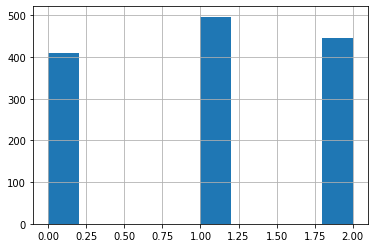

In [ ]:
pd.Series(y[0]).hist()

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   02_fc_data_preparation.ipynb
	modified:   09_ak_experimenting_lstm-2.ipynb
	deleted:    ../pipelines/multi_task_price_change_prediction/DataPreparation.py

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git config --global user.email "aysenurkulunk0@gmail.com"
!git config --global user.name "Aysenur"

In [ ]:
!git add ../pipelines/multi_task_price_change_prediction/experiment_lstm.py
!git add ../pipelines/multi_task_price_change_prediction/experiment_mha.py
!git commit -m "experimentation extended for both indicators and imfs"

[master bc27e8c] experimentation extended for both indicators and imfs
 2 files changed, 23 insertions(+), 7 deletions(-)


In [ ]:
!git push

Counting objects: 6, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 882 bytes | 882.00 KiB/s, done.
Total 6 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/aysenurk/multi_task_price_change_prediction.git
   a48fe07..bc27e8c  master -> master
